In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log

In [42]:
train_set = pd.read_csv('../Comp/education-attainment-prediction-2025/CENSUS_ED_ATTN.csv')
test_set = pd.read_csv('../Comp/education-attainment-prediction-2025/Census_Test.csv')

A_HGA is our target variable

In [43]:
def clean_split_data(df, target, train_size=0.70, tune_size=0.15, random_state=21):
    df['score'] = pd.cut(df['A_HGA'], bins=[0, 40, 46], labels=['no', 'yes'])
    df = df.dropna(subset=['score'])  # Drop rows with NaN in the 'score' column
    #numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(['score'])
    #scaler = preprocessing.MinMaxScaler()
    #df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    X = df.drop(columns=['A_HGA', 'score']) 
    y = df[target].astype('category')

    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(train_set, 'score')

In [44]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

In [45]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']
#only go to 5, because everything after is diminishing returns
param={"max_depth" : [1,2,3,4,5],
           }

In [46]:
cl= DecisionTreeClassifier(random_state=1000)

search = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf, refit='f1_macro')

In [47]:
model = search.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1000)


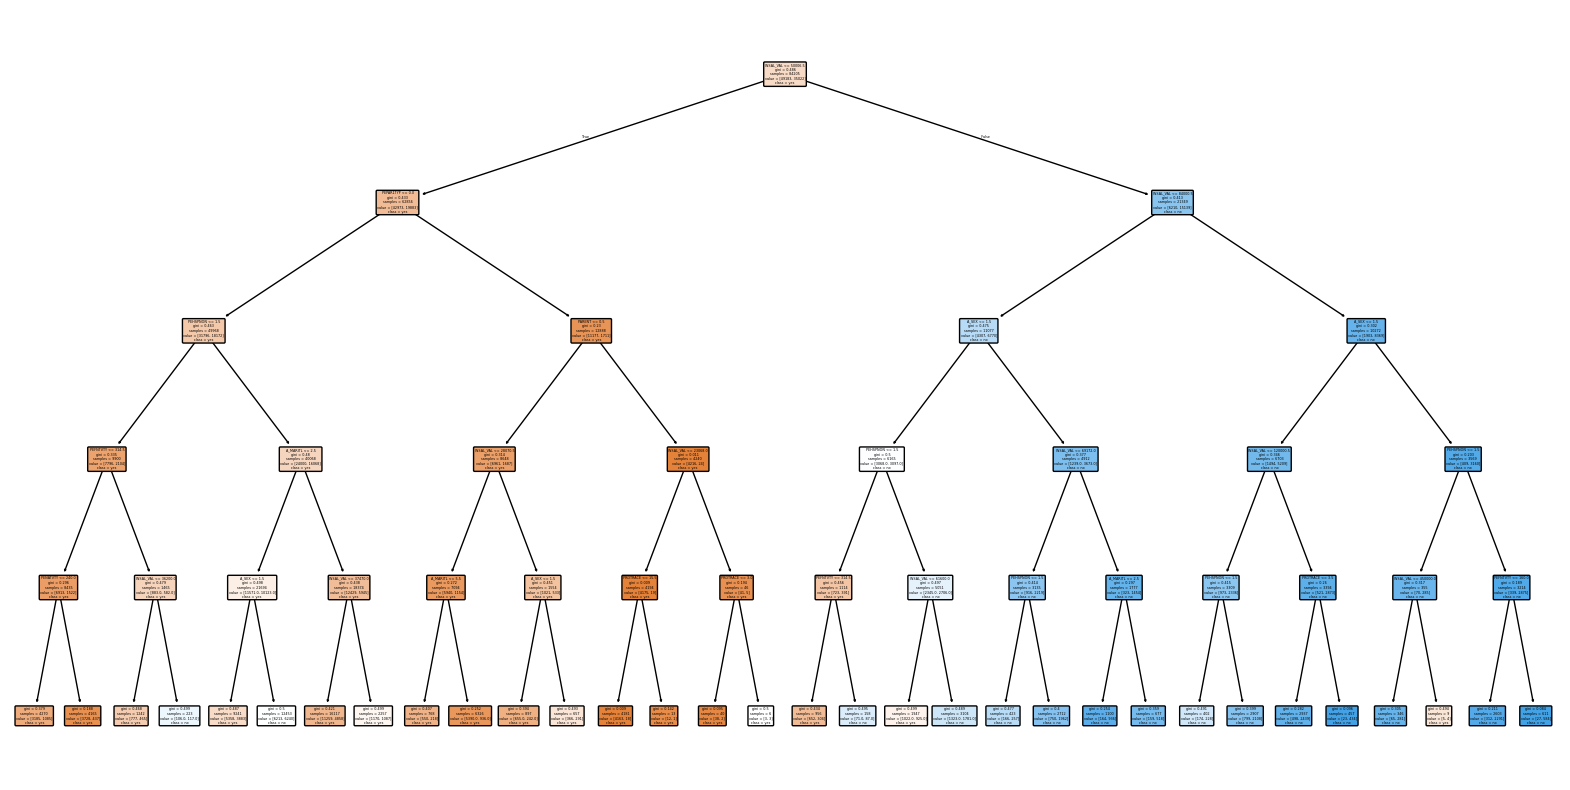

In [48]:
best= model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, rounded=True)
plt.show()

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.689874  0.652928  0.652928  0.652060    0.004338  0.004979   
1      2  0.689874  0.652928  0.652928  0.652060    0.004338  0.004979   
2      3  0.690389  0.646987  0.646987  0.641538    0.004168  0.007015   
3      4  0.693885  0.654847  0.654847  0.653228    0.004424  0.005152   
4      5  0.693334  0.672772  0.672772  0.673638    0.004654  0.011473   

   bal_accSD      f1SD  
0   0.004979  0.005686  
1   0.004979  0.005686  
2   0.007015  0.010800  
3   0.005152  0.005974  
4   0.011473  0.013216  


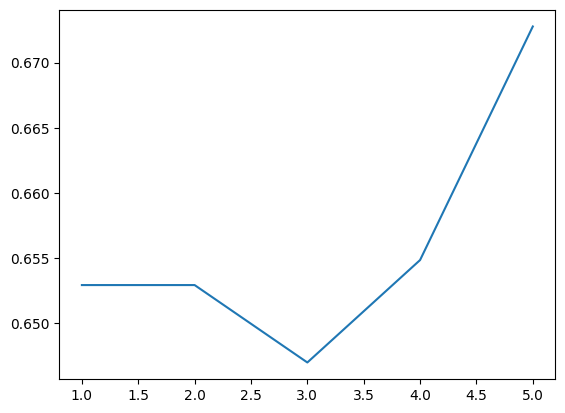

In [49]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Accuracy')

           importance
WSAL_VAL     0.646552
PEPAR1TYP    0.123940
PEHSPNON     0.074782
A_SEX        0.054003
A_MARITL     0.049768
PARENT       0.023158
PEFNTVTY     0.015622
PENATVTY     0.010645
PRDTRACE     0.001531
PEAFEVER     0.000000
PEINUSYR     0.000000
PRCITSHP     0.000000
ERN_SRCE     0.000000
ANN_VAL      0.000000


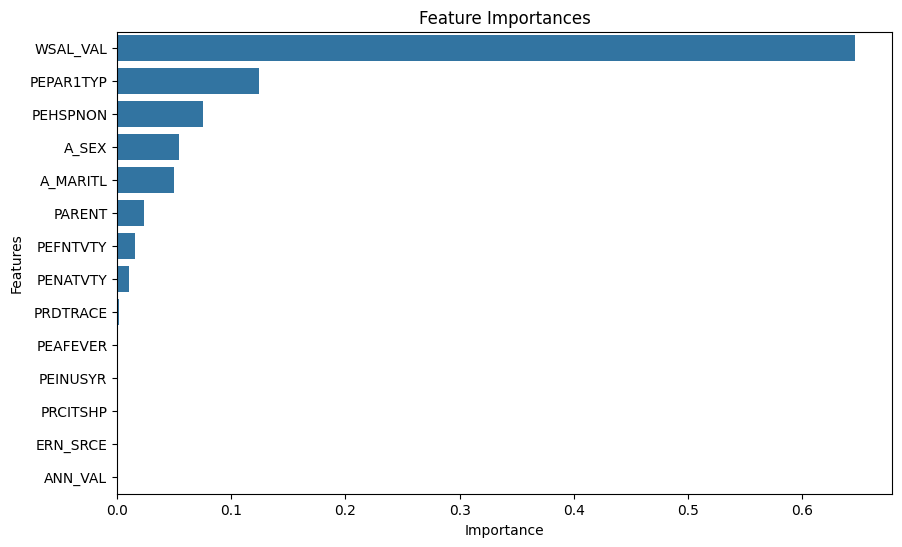

In [50]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [51]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
  Label  Percentage
0    no   63.495289
1   yes   36.504711


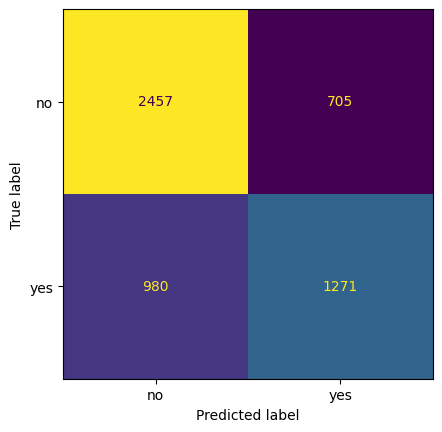

In [52]:
print(ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['no', 'yes'], colorbar=False))

In [53]:
from sklearn.metrics import precision_score, classification_report

# Predict on test set using best estimator
y_pred = search.best_estimator_.predict(X_test)

# Macro precision
macro_prec = precision_score(y_test, y_pred, average='macro')
print(f"Macro Precision on Test Set: {macro_prec:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Macro Precision on Test Set: 0.6876

Classification Report:
              precision    recall  f1-score   support

          no     0.7223    0.7810    0.7505     17917
         yes     0.6529    0.5783    0.6133     12759

    accuracy                         0.6967     30676
   macro avg     0.6876    0.6797    0.6819     30676
weighted avg     0.6934    0.6967    0.6934     30676



In [54]:
# Predict the target variable for the test set
test_predictions = model.best_estimator_.predict(test_set)

# Add predictions to the test set
test_set['Predicted_Score'] = test_predictions

print(test_set.head())
# Keep only the Predicted_Score and index
test_set = test_set[['Predicted_Score']]

# Save the predictions to a CSV file
test_set.to_csv('predictions.csv', index=True)

   A_MARITL  A_SEX  PEAFEVER  PARENT  PENATVTY  PEFNTVTY  PEHSPNON  PEINUSYR  \
0         7      2        -1       1        57        57         2         0   
1         1      1         2       0       233       233         2         5   
2         1      2         2       0       233       233         2        10   
3         7      1         2       0        57       233         2         0   
4         7      1        -1       1        57       233         2         0   

   PEPAR1TYP  PRCITSHP  PRDTRACE  ERN_SRCE  WSAL_VAL  ANN_VAL Predicted_Score  
0          1         1         4         0         0        0              no  
1         -1         4         4         1    120000        0             yes  
2         -1         4         4         1     38000        0             yes  
3          1         1         4         0         0        0              no  
4          1         1         4         0         0        0              no  
